In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  9 00:27:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [4]:
## Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [5]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [6]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:

# os.chdir('./drive')
import os
os.listdir()

['.config', 'gdrive', 'adc.json', 'drive', 'sample_data']

In [8]:
# suppose you make a directory called "try_colab" under your google drive
# you can change this path to the directory you want to work at 
path = './drive/STATSM231A/HW4' 
os.chdir(path)

os.listdir('./')

['mnist_data',
 'hw4_VAE_CNN.ipynb',
 'vae_loss.png',
 'hw4_GAN.ipynb',
 'MNIST_DCGAN_results',
 'MNIST_GAN_results',
 'data',
 'hw4_DCGAN.ipynb',
 'Copy of hw4_GAN.ipynb',
 'hw4_VAE.ipynb']

In [ ]:
# install package pytorch lightening
# ! pip install pytorch-lightning
  

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random 

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:

class VAE(nn.Module):
    def __init__(self, x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [11]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [12]:

optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [13]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [14]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [15]:
train_loss_hist = []
test_loss_hist = []
Num_epoch = 25
for epoch in range(1, Num_epoch):
    train_loss_hist.append(train(epoch))
    test_loss_hist.append(test())

====> Epoch: 1 Average loss: 178.1774
====> Test set loss: 162.2717
====> Epoch: 2 Average loss: 158.0003
====> Test set loss: 155.3847
====> Epoch: 3 Average loss: 152.8025
====> Test set loss: 151.0854
====> Epoch: 4 Average loss: 149.6806
====> Test set loss: 149.0157
====> Epoch: 5 Average loss: 147.5059
====> Test set loss: 146.8473
====> Epoch: 6 Average loss: 145.9894
====> Test set loss: 146.2183
====> Epoch: 7 Average loss: 144.9563
====> Test set loss: 144.9950
====> Epoch: 8 Average loss: 144.0609
====> Test set loss: 144.6721
====> Epoch: 9 Average loss: 143.2900
====> Test set loss: 144.0362
====> Epoch: 10 Average loss: 142.5727
====> Test set loss: 143.5384
====> Epoch: 11 Average loss: 141.9865
====> Test set loss: 142.4453
====> Epoch: 12 Average loss: 141.4455
====> Test set loss: 142.3876
====> Epoch: 13 Average loss: 140.9747
====> Test set loss: 142.2779
====> Epoch: 14 Average loss: 140.6934
====> Test set loss: 141.6039
====> Epoch: 15 Average loss: 140.2321
====

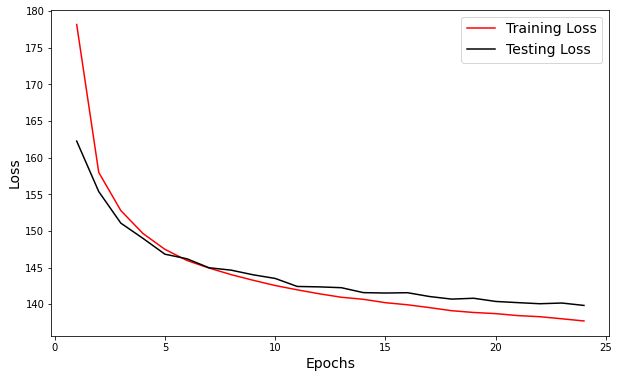

In [16]:
plt.figure(figsize = (10,6))
plt.plot(np.arange(1,Num_epoch), train_loss_hist, color = 'red', label = 'Training Loss')
plt.plot(np.arange(1,Num_epoch), test_loss_hist, color = 'k', label = 'Testing Loss')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.legend(fontsize = 14)
plt.savefig('vae_loss.png')

In [17]:
with torch.no_grad():
    z = torch.randn(25, 2).cuda()
    sample = vae.decoder(z).cuda()
    sample.view(25, 1, 28, 28)
    save_image(sample.view(25, 1, 28, 28), './mnist_data/sample_' + '.png')
    

In [18]:
sample.shape

torch.Size([25, 784])

In [38]:
import itertools
fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)

def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100))
    z_ = Variable(z_.cuda(), volatile=True)

    net.eval()
    if isFix:
        test_images = vae.decoder(fixed_z_)
    else:
        test_images = vae.decoder(z_)
    net.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


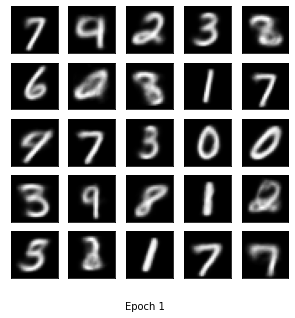

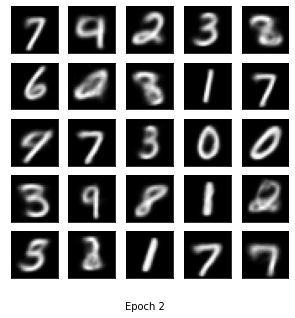

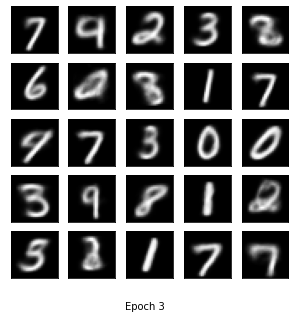

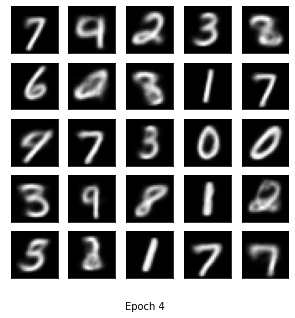

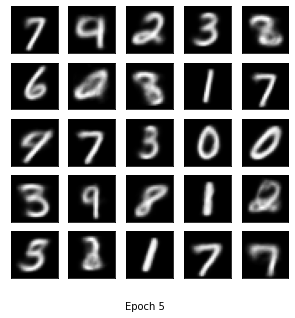

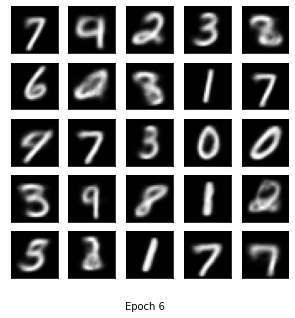

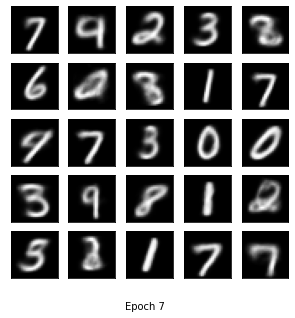

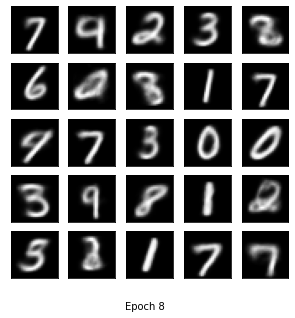

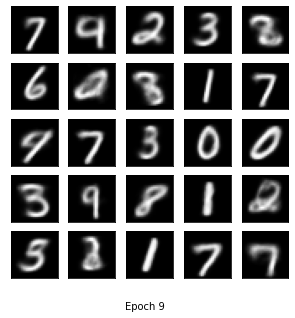

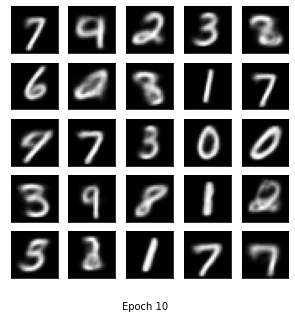

In [39]:
n_epoch = 10
for epoch in range(n_epoch):
    fixed_p = 'MNIST_GAN_results/Fixed_results/MNIST_VAE_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=False, show = True, path=fixed_p, isFix=True)


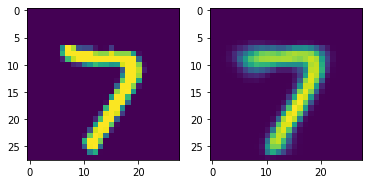

In [40]:
"""
Initialize the network and the Adam optimizer
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = VAE().to(device)

"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out1, mu, logVAR = vae(imgs)
        out = out1.view(100, 1, 28, 28)
        out = out.to(device)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        save_image(out, './mnist_data/sample_test_' + '.png')
        break

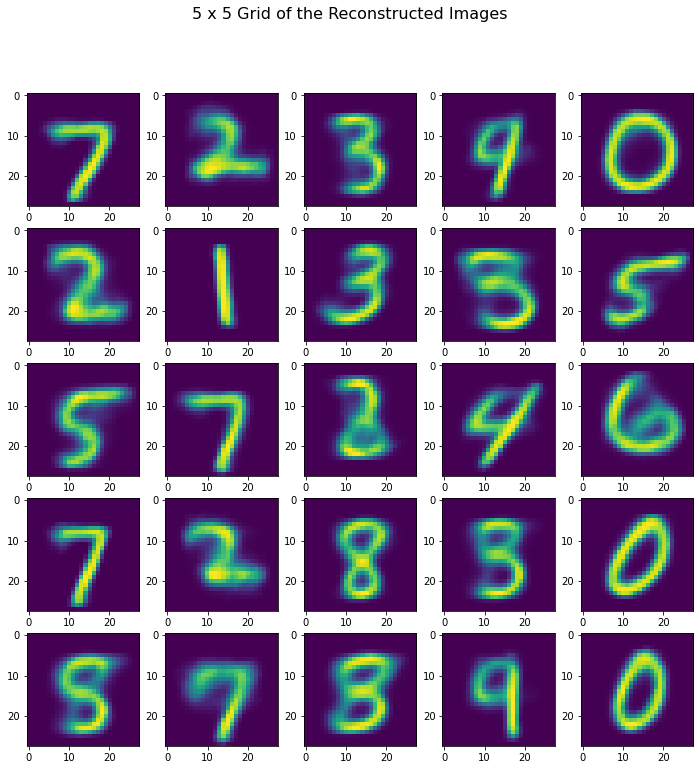

In [41]:
def imgshow(grid_size, model, reconstruction = False, imgName = 'Vae_test_images'):
  # plt.figure(figsize = (20,20))
  fig, ax = plt.subplots(grid_size[0],grid_size[1], figsize = (12,12))
  if reconstruction: 
    fig.suptitle('%s x %s Grid of the Reconstructed Images'%(grid_size[0], grid_size[1]), fontsize = 16)
  else: 
    fig.suptitle('%s x %s Grid of the Test Images'%(grid_size[0], grid_size[1]), fontsize = 16)
  s = np.arange(grid_size[0]*grid_size[1]).reshape(grid_size[0],grid_size[1])

  for i in range(grid_size[0]):
    for j in range(grid_size[1]):
      ax[i,j].imshow(model[s[i,j]].cpu().reshape(28,28))
  
  plt.show()
  fig.savefig('%s.png'%imgName)
grid_size = [5,5]

imgshow(grid_size, out, reconstruction= True, imgName = 'Vae_reconst_images')

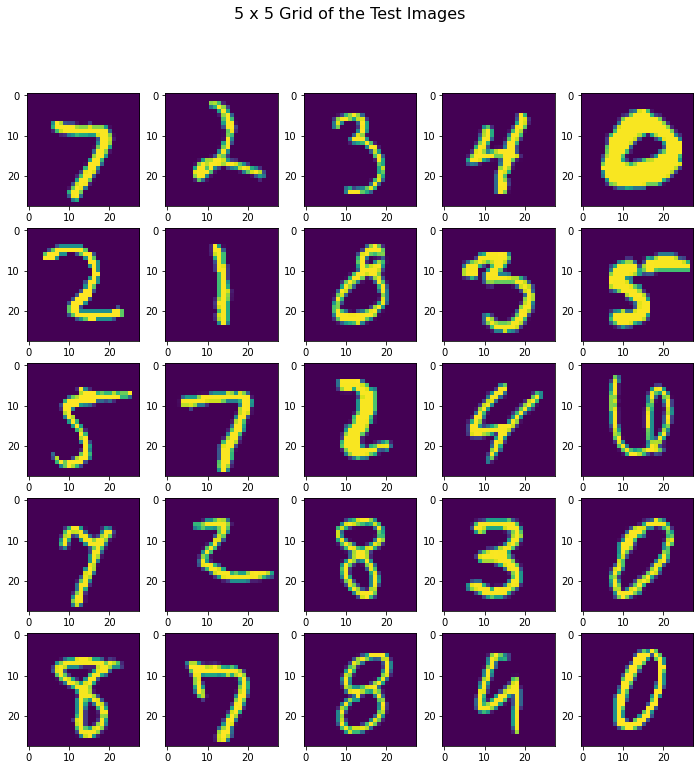

In [42]:
grid_size = [5,5]
imgshow(grid_size, imgs )